### Analysis
This notebook is used to compare results obtained from the MLDA and MCMC algorithms applied to the self created benchmark that has lower dimensionality (16 instead of the original 64 parameters). 

Note: 
- To compute the chains run one of the python files: MCMC-benchmark.py, MCMC-not-logspace.py, MCMC-not-logspace_reduced_dim.py, MLDA-benchmark.py, MLDA-not-logspace-benchmark_reduced_dim.py or MLDA-not-logspace-benchmark.py.

In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pickle 

### Load data
First we load data as a arviz inference Data object and then optionally as a dictionary containing ndarrays.

In [31]:
# load data arviz inference data
chains_MCMC = az.from_json('MCMC_chains_not_logspace\MCMC_chains_length_30000_numChains_2_h_1_32_reduced_dim_parallel.json')
with open('MCMC_chains_not_logspace\MCMC_chains_dict_length_30000_numChains_2_h_1_32_reduced_dim_parallel.pkl', 'rb') as f:
    chains_MCMC_dict = pickle.load(f)

chains_MLDA = az.from_json('MLDA_chains_not_logspace\MLDA_chains_length_30000_numChains_2_subrates_1_30_levels_0_1_2_reduced_parallel.json')

# load chains that are stored in a dictionary
with open("MLDA_chains_not_logspace\MLDA_chains_dict_length_30000_numChains_2_subrates_1_30_levels_0_1_2_reduced_dim_parallel.pkl", 'rb') as f:
    chains_MLDA_dict = pickle.load(f)


In [32]:
# compute summary statistics
summary_mcmc = az.summary(chains_MCMC)
summary_MLDA = az.summary(chains_MLDA)
#store mean to plot 
mean_mcmc = np.array(summary_mcmc['mean']).reshape((4,4))
mean_MLDA = np.array(summary_MLDA['mean']).reshape((4,4))

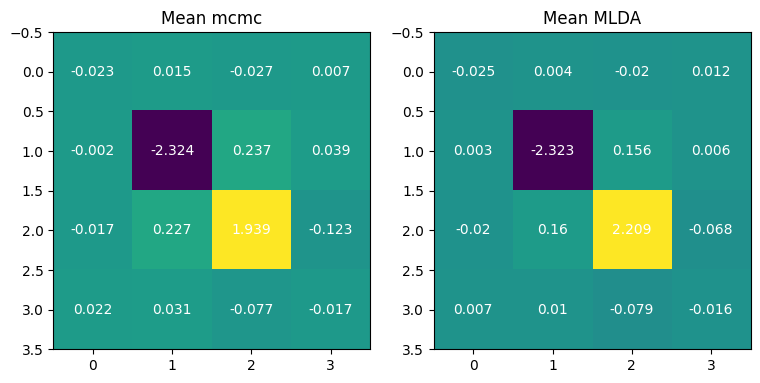

In [33]:
# plot mean
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(9,9))
im1 = ax[0].imshow(mean_mcmc)
ax[0].set_title('Mean mcmc')
for i in range(4):
    for j in range(4):
        text = ax[0].text(j,i, np.round(mean_mcmc[i, j],3),
                    ha="center", va="center", color="w")
        
im1 = ax[1].imshow(mean_MLDA)
ax[1].set_title('Mean MLDA')
for i in range(4):
    for j in range(4):
        text = ax[1].text(j,i, np.round(mean_MLDA[i, j],3),
                    ha="center", va="center", color="w")
        

### Paths

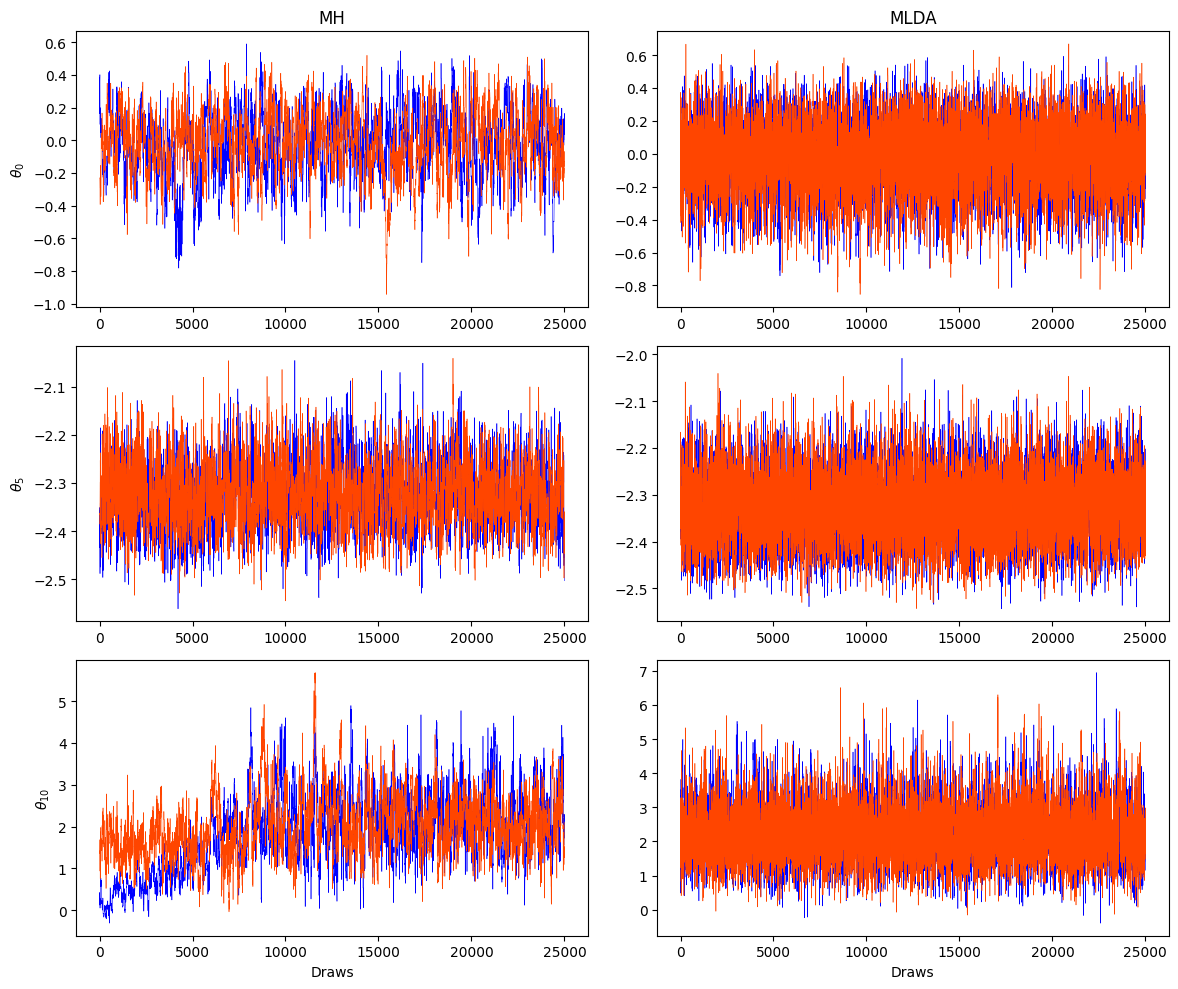

In [9]:
path_indices = [0,5,10]

fig ,axs = plt.subplots(nrows=len(path_indices), ncols=2, figsize=(12,10))

for idx, i in enumerate(path_indices):
    axs[idx,0].plot(chains_MCMC_dict['chain_0'][:,i],'b', linewidth=0.4)
    axs[idx,0].plot(chains_MCMC_dict['chain_1'][:,i], 'orangered', linewidth=0.4)
    axs[idx,1].plot(chains_MLDA_dict['chain_0'][:,i],'b', linewidth=0.4)
    axs[idx,1].plot(chains_MLDA_dict['chain_1'][:,i], 'orangered', linewidth=0.4)
    axs[idx,0].set_ylabel(r'$\theta_{%d}$'%i)


axs[0,0].set_title('MH')
axs[0,1].set_title('MLDA')

axs[-1,0].set_xlabel('Draws')
axs[-1,1].set_xlabel('Draws')


fig.tight_layout()


### Effective samples per second

In [10]:
# compute effective sample size
# divided by time it took to compute the samples (this is stored in a txt file)
MCMC_ess = az.ess(chains_MCMC)
MCMC_ess = MCMC_ess.to_array().to_numpy()
MCMC_ess_time = MCMC_ess/1160 # the correct time is stored in the TIME.txt file and has to be inserted correctly

MLDA_ess = az.ess(chains_MLDA)
MLDA_ess = MLDA_ess.to_array().to_numpy() 
MLDA_ess_time = MLDA_ess/13287

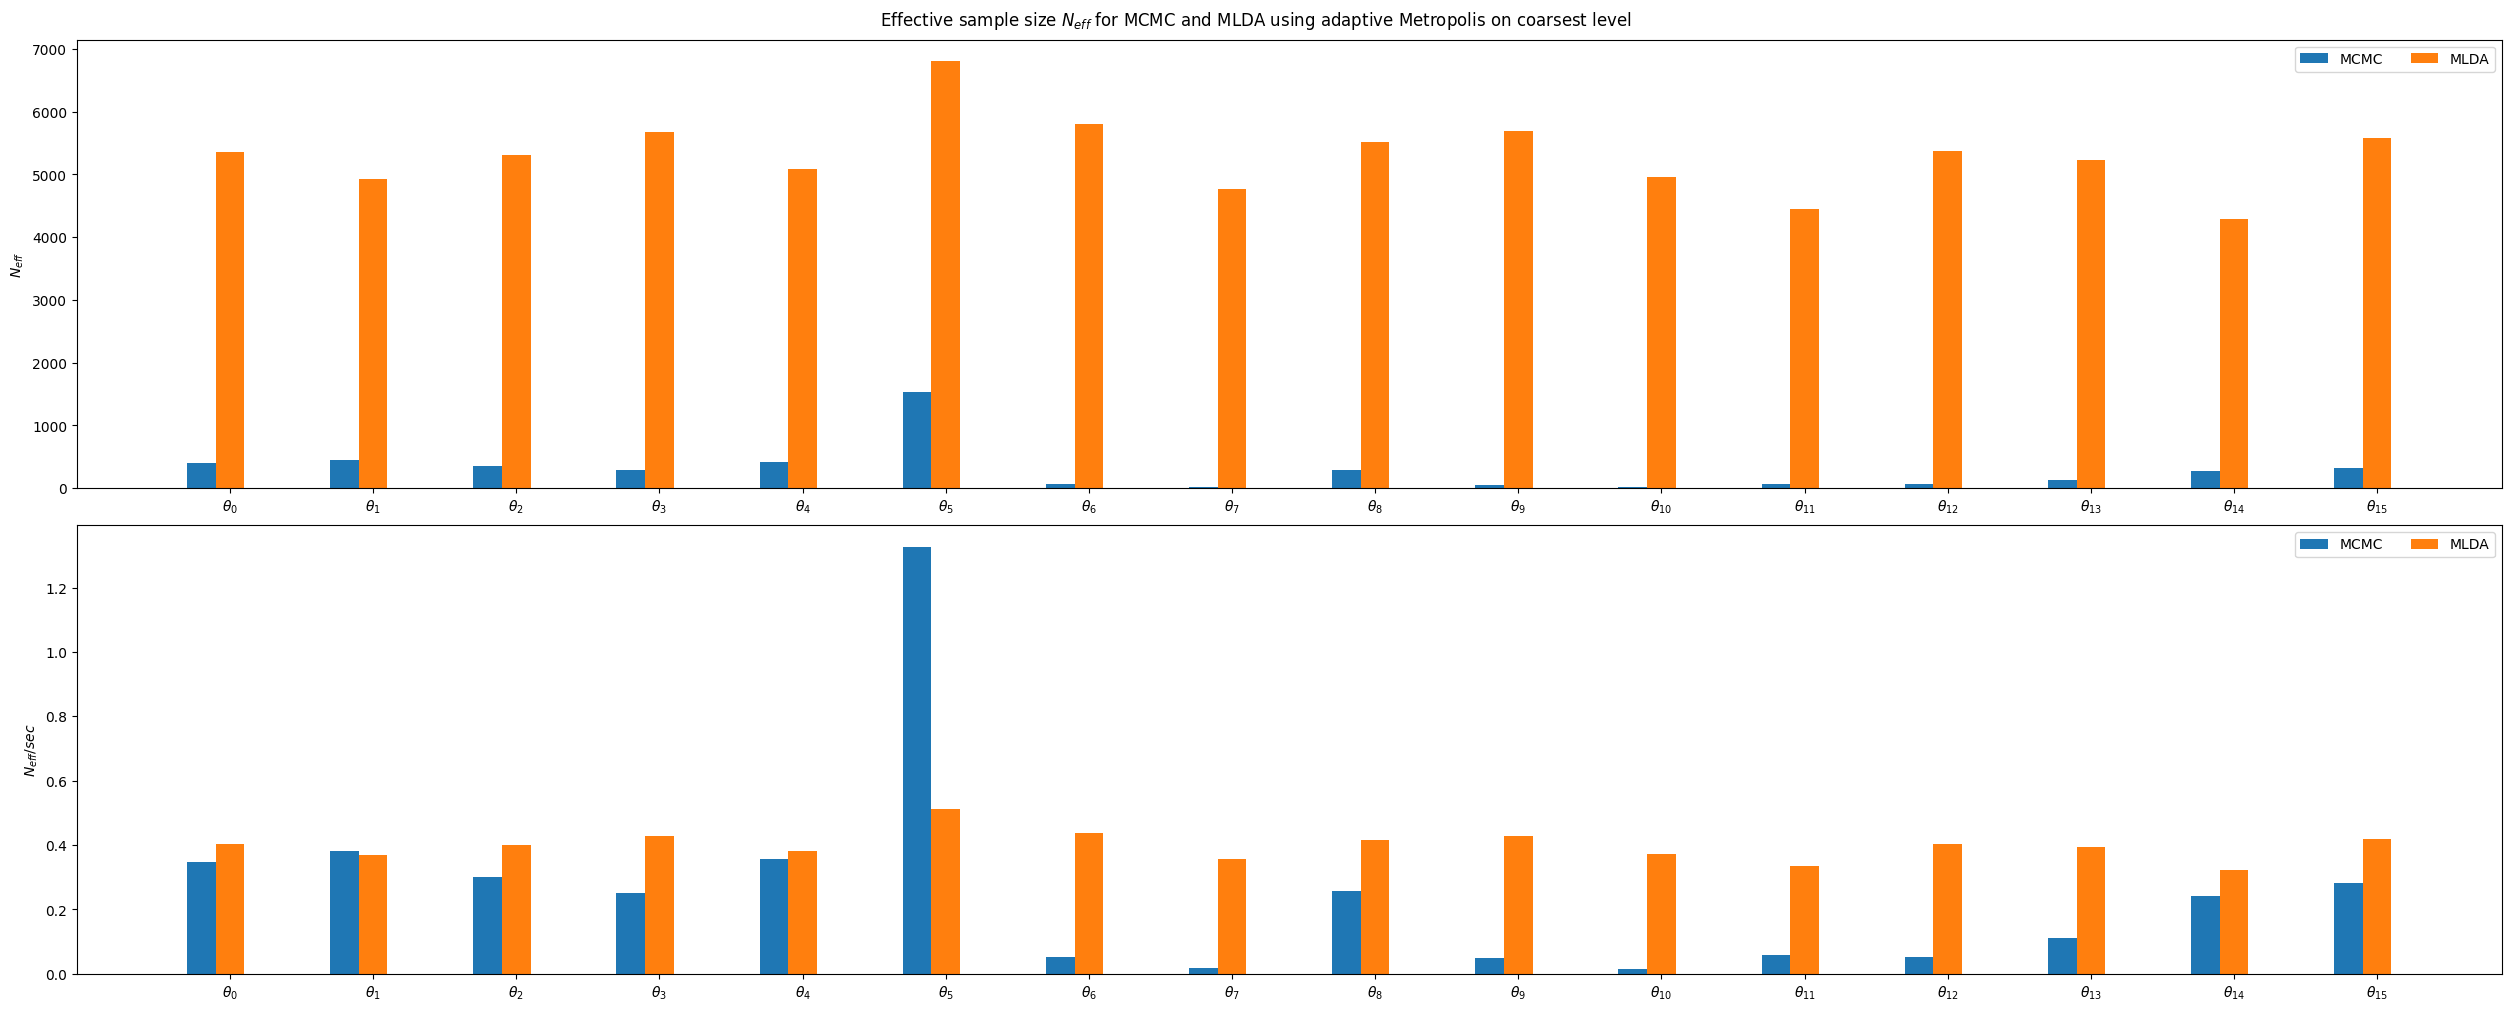

In [30]:
path_indices = [i for i in range(16)]
theta = [r'$\theta_{%d}$'%d for d in path_indices]
N_eff = {
    'MCMC': MCMC_ess[path_indices],
    'MLDA': MLDA_ess[path_indices],
}

N_eff_time = {
    'MCMC': MCMC_ess_time[path_indices],
    'MLDA': MLDA_ess_time[path_indices],

}

x = np.arange(len(theta))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(nrows=2, figsize=(25,10), layout='constrained')

for attribute, measurement in N_eff.items():
    offset = width * multiplier
    rects = ax[0].bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

multiplier = 0
for attribute, measurement in N_eff_time.items():
    offset = width * multiplier
    rects = ax[1].bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[0].set_ylabel(r'$N_{eff}$')
ax[0].set_xticks(x + width, theta)
ax[0].legend(ncols=3)
ax[1].set_ylabel(r'$N_{eff}/sec$')
ax[1].set_xticks(x + width, theta)
ax[1].legend(ncols=3)

fig.suptitle(r'Effective sample size $N_{eff}$ for MCMC and MLDA using adaptive Metropolis on coarsest level')
plt.show()

As one can see, MLDA produces way more effective samples. Eventhough the computational time is longer by calling coarser models the effectrive sample size per time still pays off on almost all modes.